# Импорты

In [ ]:
import os, random
from collections import Counter
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

import kagglehub

In [ ]:
# Задаем константы
RANDOM = 42
torch.manual_seed(RANDOM)

# GPU

In [ ]:
# Используем GPU T4 в Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используем устройство:", device)

Используем устройство: cuda


# Загрузка датасета

In [ ]:
dataset_path = kagglehub.dataset_download('asdasdasasdas/garbage-classification')

# Находим папку с классами
def find_class_folders(root):
    for root_dir, dirs, _ in os.walk(root):
        if set(['metal','paper','glass','trash','plastic','cardboard']).issubset(set(dirs)):
            return os.path.join(root_dir)
    return None

data_dir = find_class_folders(dataset_path)
print("Путь к данным:", data_dir)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Путь к данным: /kaggle/input/garbage-classification/Garbage classification/Garbage classification


In [ ]:
# Проверяем количество изображений
total_files = sum(len(files) for _, _, files in os.walk(data_dir))
print("Всего изображений:", total_files)
print("Классы:", os.listdir(data_dir))

Всего изображений: 2527
Классы: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


# Преобразования и Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
dataset = ImageFolder(data_dir, transform=transform)

# Разделение на обучающую, валидационную и тестовую выборки

In [ ]:
def stratified_split(dataset, train_ratio=0.6, val_ratio=0.2, random_state=RANDOM):
    targets = np.array(dataset.targets)
    indices = np.arange(len(dataset))
    train_idx, temp_idx = train_test_split(
        indices, test_size=1-train_ratio, stratify=targets, random_state=random_state
    )
    temp_targets = targets[temp_idx]
    val_ratio_adjusted = val_ratio / (1-train_ratio)
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=1-val_ratio_adjusted, stratify=temp_targets, random_state=random_state
    )
    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

train_ds, val_ds, test_ds = stratified_split(dataset)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 1516, Val: 505, Test: 506


In [ ]:
def class_distribution(subset):
    labels = [dataset.targets[i] for i in subset.indices]
    return Counter(labels)

print("Распределение по классам:")
print("Train:", class_distribution(train_ds))
print("Val:  ", class_distribution(val_ds))
print("Test: ", class_distribution(test_ds))

Распределение по классам:
Train: Counter({3: 356, 1: 301, 4: 289, 2: 246, 0: 242, 5: 82})
Val:   Counter({3: 119, 1: 100, 4: 96, 2: 82, 0: 80, 5: 28})
Test:  Counter({3: 119, 1: 100, 4: 97, 2: 82, 0: 81, 5: 27})


# Даталоадер

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=False, pin_memory=True)

# Функции для обучения

In [ ]:
def accuracy(outputs, labels):
    return (outputs.argmax(dim=1) == labels).float().mean()

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = (x.to(device) for x in batch)
        logits = self(images)
        return F.cross_entropy(logits, labels)

    def validation_step(self, batch):
        images, labels = (x.to(device) for x in batch)
        logits = self(images)
        return {'val_loss': F.cross_entropy(logits, labels),
                'val_acc': accuracy(logits, labels)}

    def validation_epoch_end(self, outputs):
        return {k: torch.stack([x[k] for x in outputs]).mean().item() for k in outputs[0]}

    def epoch_end(self, epoch, result):
        print(f"Эпоха {epoch+1}: train_loss={result['train_loss']:.4f}, "
              f"val_loss={result['val_loss']:.4f}, val_acc={result['val_acc']:.4f}")

# Модели

In [ ]:
# 1) Простая baseline модель
class SimpleCNN(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:
# 2) Предобученная ResNet
class ResNetModel(ImageClassificationBase):
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.network = resnet50(weights=weights)
        if freeze_backbone:
            for param in self.network.parameters():
                param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
    def forward(self, x):
        return self.network(x)

# Обучение

In [ ]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            outputs = [model.validation_step(batch) for batch in val_dl]
        result = model.validation_epoch_end(outputs)
        result['train_loss'] = np.mean(train_losses)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Тесты

In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Обучение

# Предсказания

In [ ]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    return dataset.classes[yb.argmax(dim=1).item()]

def show_predictions_grid(subset, model, n=9):
    ds = subset.dataset
    indices = random.sample(range(len(subset)), n)

    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols  # округляем вверх

    plt.figure(figsize=(4*n_cols, 4*n_rows))

    for i, idx in enumerate(indices):
        img, label = subset[idx]
        pred = predict_image(img, model)

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f'True: {ds.classes[label]}\nPred: {pred}', fontsize=10)

    plt.tight_layout()
    plt.show()

# Модели

In [ ]:
baseline_model = SimpleCNN(len(dataset.classes)).to(device)
resnet_model = ResNetModel(len(dataset.classes), freeze_backbone=True).to(device)

In [ ]:
# Простая baseline модель
print("Обучаем baseline CNN...")
baseline_history = fit(5,
                       0.001,
                       baseline_model,
                       train_dl, val_dl)


Обучаем baseline CNN...
Эпоха 1: train_loss=1.6173, val_loss=1.5074, val_acc=0.3751
Эпоха 2: train_loss=1.3110, val_loss=1.3584, val_acc=0.4771
Эпоха 3: train_loss=1.1436, val_loss=1.1653, val_acc=0.5692
Эпоха 4: train_loss=0.9473, val_loss=1.1190, val_acc=0.5833
Эпоха 5: train_loss=0.8360, val_loss=1.1003, val_acc=0.5760


*Дальше 5 эпох при этих параметрах результаты модели не улучшаются

In [ ]:
# Предобученная ResNet модель
print("Обучаем ResNet...")
resnet_history = fit(100,
                     0.00005,
                     resnet_model,
                     train_dl, val_dl)

Обучаем ResNet...
Эпоха 1: train_loss=1.6951, val_loss=1.6314, val_acc=0.3893
Эпоха 2: train_loss=1.5662, val_loss=1.5179, val_acc=0.4808
Эпоха 3: train_loss=1.4619, val_loss=1.4238, val_acc=0.5355
Эпоха 4: train_loss=1.3680, val_loss=1.3441, val_acc=0.6241
Эпоха 5: train_loss=1.2973, val_loss=1.2753, val_acc=0.6419
Эпоха 6: train_loss=1.2276, val_loss=1.2114, val_acc=0.6732
Эпоха 7: train_loss=1.1651, val_loss=1.1640, val_acc=0.6873
Эпоха 8: train_loss=1.1143, val_loss=1.1042, val_acc=0.6832
Эпоха 9: train_loss=1.0599, val_loss=1.0682, val_acc=0.7088
Эпоха 10: train_loss=1.0311, val_loss=1.0298, val_acc=0.6990
Эпоха 11: train_loss=0.9873, val_loss=0.9897, val_acc=0.7391
Эпоха 12: train_loss=0.9503, val_loss=0.9618, val_acc=0.7388
Эпоха 13: train_loss=0.9286, val_loss=0.9310, val_acc=0.7447
Эпоха 14: train_loss=0.8915, val_loss=0.9120, val_acc=0.7466
Эпоха 15: train_loss=0.8804, val_loss=0.8910, val_acc=0.7584
Эпоха 16: train_loss=0.8447, val_loss=0.8624, val_acc=0.7642
Эпоха 17: train

# Оценка на тесте

Baseline accuracy: 0.6245
ResNet accuracy: 0.8320

Отчёт по классам ResNet:

              precision    recall  f1-score   support

   cardboard       0.88      0.88      0.88        81
       glass       0.83      0.84      0.84       100
       metal       0.81      0.88      0.84        82
       paper       0.83      0.87      0.85       119
     plastic       0.85      0.84      0.84        97
       trash       0.60      0.33      0.43        27

    accuracy                           0.83       506
   macro avg       0.80      0.77      0.78       506
weighted avg       0.83      0.83      0.83       506



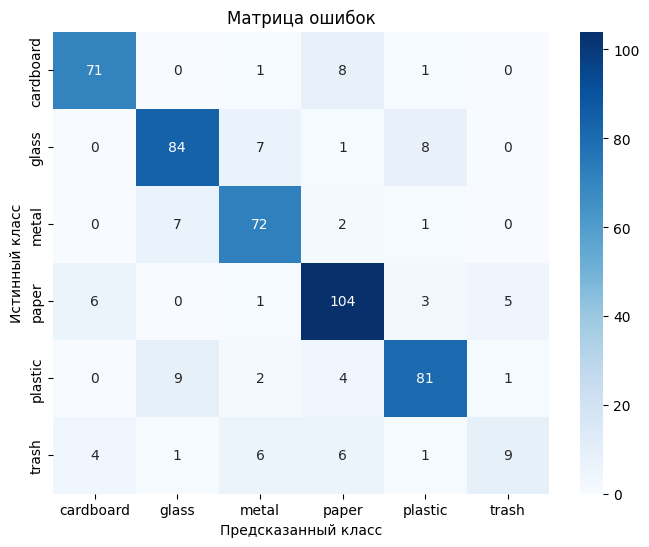

In [ ]:
y_true_base, y_pred_base = evaluate_on_test(baseline_model, test_dl)
y_true_res, y_pred_res = evaluate_on_test(resnet_model, test_dl)

print(f"Baseline accuracy: {(y_true_base==y_pred_base).mean():.4f}")
print(f"ResNet accuracy: {(y_true_res==y_pred_res).mean():.4f}")

print("\nОтчёт по классам ResNet:\n")
print(classification_report(y_true_res, y_pred_res, target_names=dataset.classes))

cm = confusion_matrix(y_true_res, y_pred_res)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
plt.xlabel("Предсказанный класс"); plt.ylabel("Истинный класс"); plt.title("Матрица ошибок")
plt.show()

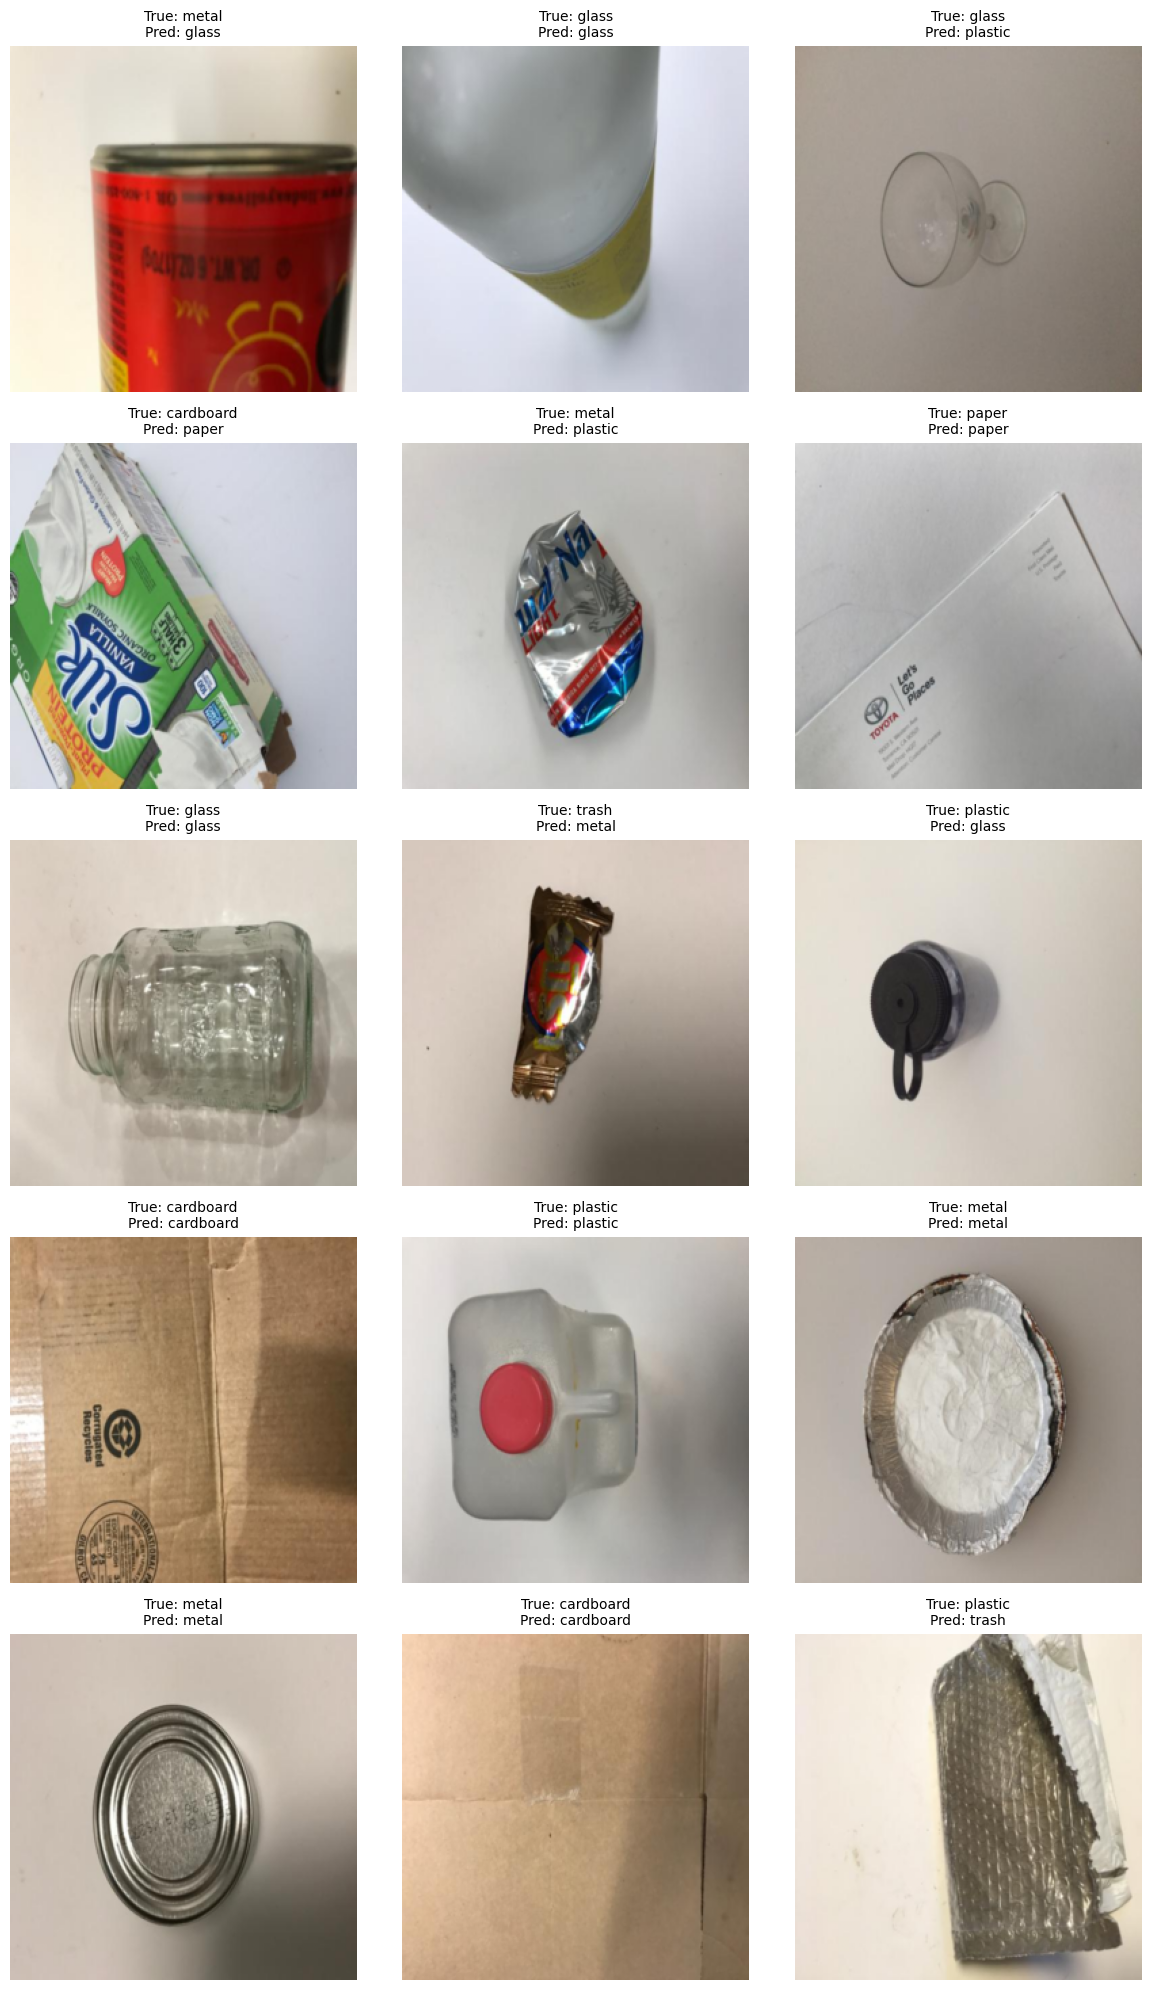

In [ ]:
show_predictions_grid(test_ds, resnet_model, n=15)

# Визуализация

In [ ]:
def plot_metrics(history):
    if not history:
        print("История обучения пуста!")
        return

    # Проверяем наличие ключей
    required_keys = ['train_loss', 'val_loss', 'val_acc']
    for key in required_keys:
        if key not in history[0]:
            print(f"В словарях истории нет ключа '{key}'")
            return

    plt.figure(figsize=(14,5))

    # Потери
    plt.subplot(1,2,1)
    plt.plot([x['train_loss'] for x in history], '-bx', label='Обучение')
    plt.plot([x['val_loss'] for x in history], '-rx', label='Валидация')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.title('Потери')
    plt.legend()
    plt.grid(True)

    # Точность
    plt.subplot(1,2,2)
    plt.plot([x['val_acc'] for x in history], '-gx', label='Валидация')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.title('Точность на валидации')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

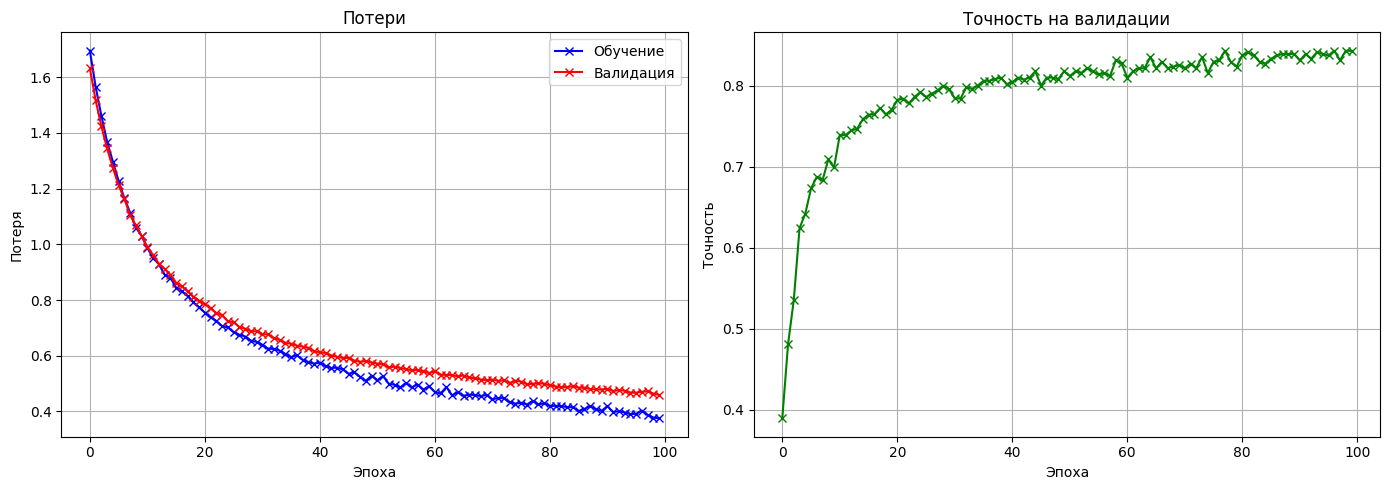

In [ ]:
plot_metrics(resnet_history)

# Предсказание на случайных изображениях из поисковика, просто чтобы проверить на новых, "случайных" данных

In [ ]:
external_urls = {
    "plastic.jpg": "https://www.pngkey.com/png/detail/480-4801444_quality-plastic-bottle.png",
    "cardboard.jpg": "https://as2.ftcdn.net/jpg/00/30/06/05/1000_F_30060579_6luL31Afvg7WYk058toO5cuQE069ufRr.jpg",
    "glass.jpg": "https://images.rawpixel.com/image_800/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvcHgxNjA2MDc3LWltYWdlLWt3dnlvOHg5LmpwZw.jpg",
    "metal.jpg": "https://cdnstatic.rg.ru/uploads/images/217/02/13/11p_1k_banka.jpg",
    "paper.jpg": "https://img.freepik.com/free-photo/newspaper-background-concept_23-2149501577.jpg?semt=ais_hybrid&w=740",
    "trash.jpg": "https://i.otzyvru.com/2019/12/10/frutonyanya_5defdd6e52be0.jpg"
}

# Скачивание изображений
for filename, url in external_urls.items():
    r = requests.get(url, headers={"User-Agent": "PythonBot/1.0"})
    with open(filename, "wb") as f:
        f.write(r.content)
    print(f"{filename} успешно скачан")

plastic.jpg успешно скачан
cardboard.jpg успешно скачан
glass.jpg успешно скачан
metal.jpg успешно скачан
paper.jpg успешно скачан
trash.jpg успешно скачан


In [ ]:
# Функция для предсказания и отображения внешнего изображения
def predict_external_image(image_path, model, transform=transform):
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img)
    plt.imshow(img_t.permute(1,2,0))
    plt.axis('off')
    plt.show()
    print("Модель определяет:", predict_image(img_t, model))

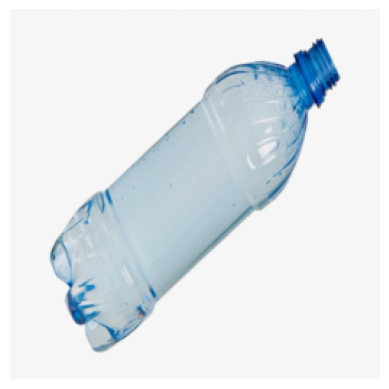

Модель определяет: plastic


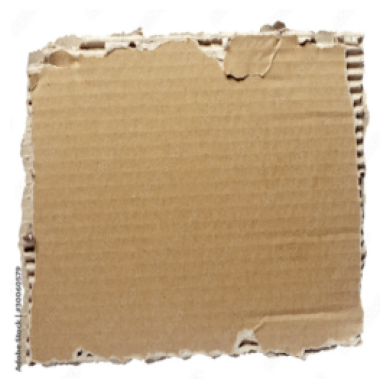

Модель определяет: cardboard


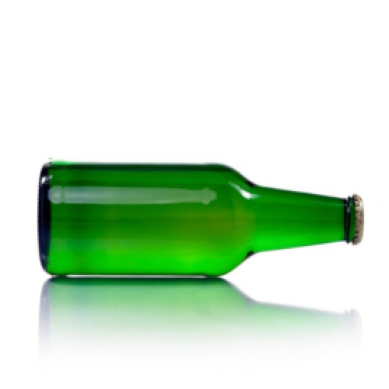

Модель определяет: glass


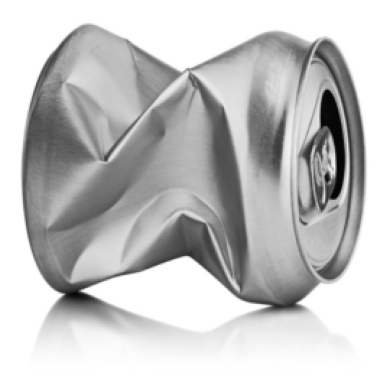

Модель определяет: metal


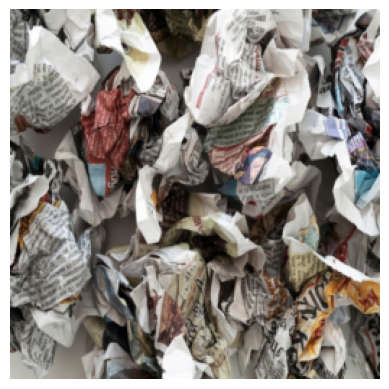

Модель определяет: paper


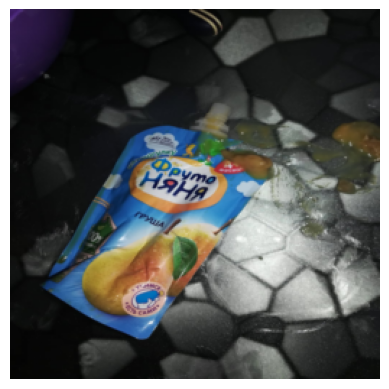

Модель определяет: cardboard


In [ ]:
# Примеры предсказаний
for filename in external_urls.keys():
    predict_external_image(filename, resnet_model)